# 0. Importing Packages

In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm

# 1. Loading IFU Data

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = 0.3033
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var, cont
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
binned_continuum = vb['cont']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [3]:
binned_spectrum.shape

(5601, 356)

In [4]:
data0 = binned_spectrum - binned_continuum
vari0 = binned_variance
cont0 = binned_continuum

dat = data0 * (1.0+redshift)
var = vari0 * (1.0+redshift)**2.0
cont = cont0 * (1.0+redshift)

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [5]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.1*np.sum((binNpix == 1)))
print(0.1*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 1.1. Retrieving maximum spectrum

In [6]:
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)
n_bin = data_vbin[yInd, xInd]
print("Maximum intensity bin")
print(f"Bin {n_bin:d}: (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = dat[:, n_bin]
maximum_variance = var[:, n_bin]
maximum_continuum = cont[:, n_bin]

Maximum intensity bin
Bin 0: (x, y) = (16, 20)


## 1.2. Retrieving integrated spectrum with the bin's order

In [7]:
n_integrate = 16
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

## 1.3. Retrieving integrated spectrum within a circle

In [8]:
fin_cb = 'bfcube_3D.fits'

d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

d_sci[:, 0, :] = 0.
d_sci[:, :, 0] = 0.
d_sci[:, -1, :] = 0.
d_sci[:, :, -1] = 0.

d_sci2 = d_sci * (1+redshift)
d_var2 = d_var * (1+redshift)**2

In [9]:
from photutils.aperture import CircularAperture as CAp
rad = 3
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci2*msk, axis=(1, 2))
circular_variance = np.sum(d_var2*msk, axis=(1, 2))
print(circular_spectrum.shape)

Area: 28.2743 = 28.2743?  True
(5601,)


<IPython.core.display.Javascript object>


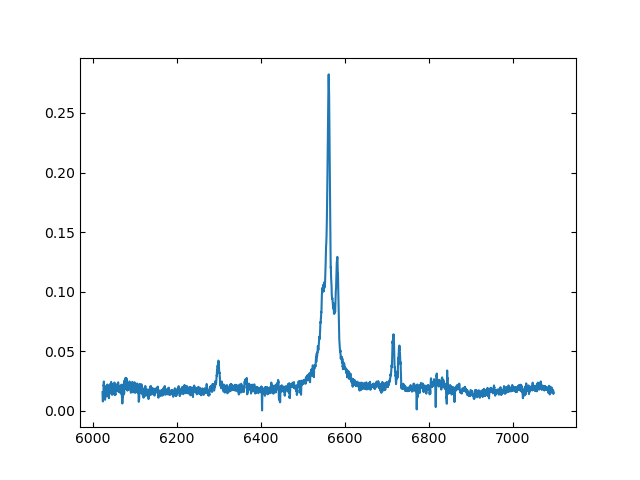

In [10]:
fig, ax = plt.subplots()
ax.plot(wav_res, circular_spectrum)

### 1.3.1. Continuum subtraction for the circular spectrum

<IPython.core.display.Javascript object>


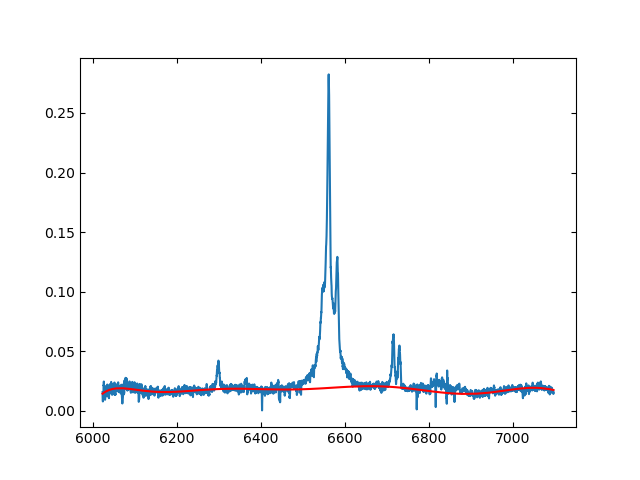

In [11]:
from specutils import Spectrum1D
from specutils.fitting import fit_continuum
from astropy import units as u
from astropy.modeling.polynomial import Chebyshev1D

# Wavelength masking range (rest-frame)
wav_msk2 = np.array([[6280, 6315],  # [OI]
                     [6455, 6635],  # [NII] + H alpha
                     [6695, 6745],  # [SII]
                     [6755, 6905]  # noisy region
                    ])
# wav_msk2 = wav_msk2*(1.0+redshift)

# Continuum fitting: polynomial relation
region = [(wav_res.min()*u.AA, wav_msk2[0,0]*u.AA)]

for j in np.arange(wav_msk2.shape[0]-1):
    region.append((wav_msk2[j,1]*u.AA, wav_msk2[j+1,0]*u.AA))
region.append((wav_msk2[wav_msk2.shape[0]-1, 1]*u.AA, wav_res.max()*u.AA))

lam = wav_res * u.AA
flx = circular_spectrum * u.Unit("1.0e-15 erg cm-2 s-1 AA-1")
tspec = Spectrum1D(spectral_axis = lam, flux = flx)
cfunc = fit_continuum(tspec, model=Chebyshev1D(10), window=region)
ccont = cfunc(tspec.spectral_axis)

fig, ax = plt.subplots()
ax.plot(wav_res, circular_spectrum)
ax.plot(wav_res, ccont.value, '-', color='red')

subcircular_spectrum = circular_spectrum - ccont.value
subcircular_variance = circular_variance
subcircular_continuum = ccont.value

In [12]:
mode = "maximum"
# "maximum" OR "integrated" OR "subcircular"

exec("fit_spectrum = copy.deepcopy("+mode+"_spectrum)")
exec("fit_variance = copy.deepcopy("+mode+"_variance)")
exec("fit_continuum = copy.deepcopy("+mode+"_continuum)")

<IPython.core.display.Javascript object>


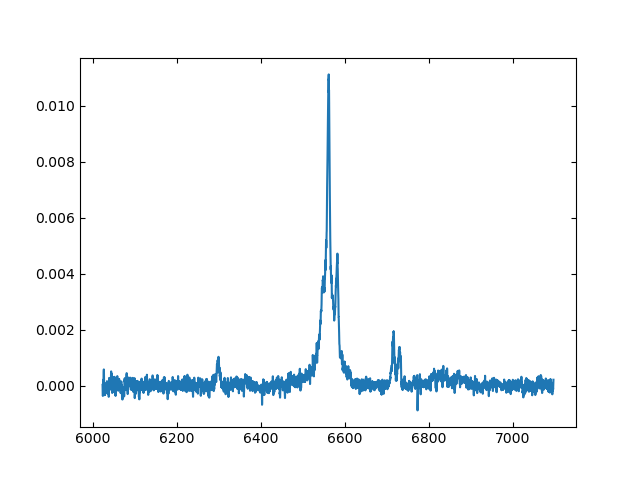

In [13]:
fig, ax = plt.subplots()
ax.plot(wav_res, fit_spectrum)

# 2. Basic Setting of Line Fitting

In [14]:
np.random.seed(0)

In [15]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multi2_gauss_cdf_scale(x, *pars):
    g1 = gauss_cdf_scale(x, pars[0], pars[1], pars[2])
    g2 = gauss_cdf_scale(x, pars[3], pars[4], pars[5])
    return g1+g2

def multi3_gauss_cdf_scale(x, *pars):
    g1 = gauss_cdf_scale(x, pars[0], pars[1], pars[2])
    g2 = gauss_cdf_scale(x, pars[3], pars[4], pars[5])
    g3 = gauss_cdf_scale(x, pars[6], pars[7], pars[8])
    return g1+g2+g3

def multi5_gauss_cdf_scale(x, *pars):
    g1 = gauss_cdf_scale(x, pars[0], pars[1], pars[2])
    g2 = gauss_cdf_scale(x, pars[3], pars[4], pars[5])
    g3 = gauss_cdf_scale(x, pars[6], pars[7], pars[8])
    g4 = gauss_cdf_scale(x, pars[9], pars[10], pars[11])
    g5 = gauss_cdf_scale(x, pars[12], pars[13], pars[14])
#     g6 = gauss_cdf_scale(x, pars[15], pars[16], pars[17])
    return g1+g2+g3+g4+g5#g6

In [16]:
def line_par(line_numbers, broad_component = False):

    if (line_numbers == 0):
#         nlines = 2
        nlines = 1
        line_names = ['OII3727']#, 'OII3729']
        line_wav = [3727.092]#, 3729.875]
        wav_fit = [3720.0, 3740.0]
#         line_model = multi2_gauss_cdf_scale
        line_model = gauss_cdf_scale
    
    if (line_numbers == 1):
        nlines = 1
        line_names = ['Hbeta']
        line_wav = [4862.68]
        wav_fit = [4855.0, 4870.0]
        line_model = gauss_cdf_scale

    if (line_numbers == 2):
        nlines = 2
        line_names = ['OIII4959', 'OIII5007']
        line_wav = [4960.295, 5008.240]
        wav_fit = [4950.0, 5015.0]
        line_model = multi2_gauss_cdf_scale

    if (line_numbers == 3):
        if broad_component:
            nlines = 5
            line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad1', 'Broad2']
            line_wav = [6549.86, 6564.61, 6585.27, 6564.61, 6564.61]
            wav_fit = [6500.0, 6625.0]
            line_model = multi5_gauss_cdf_scale
        else:
            nlines = 3
            line_names = ['NII6548', 'Halpha', 'NII6584']
            line_wav = [6549.86, 6564.61, 6585.27]
            wav_fit = [6540.0, 6595.0]
            line_model = multi3_gauss_cdf_scale

    if (line_numbers == 4):
        nlines = 2
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        wav_fit = [6710.0, 6740.0]
        line_model = multi2_gauss_cdf_scale

    if (line_numbers == 5):
        nlines = 1
        line_names = ['OI6300']
        line_wav = [6302.046]
        wav_fit = [6295.0, 6310.0]
        line_model = gauss_cdf_scale
    
    return [nlines, line_names, line_wav, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq\n')
f.close()

broad = True
if broad:
    g = open('linefit_integrated_broad.txt','w')
    g.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq flxsum_scale\n')
    g.close()

# 3. Emission Line Fitting

## 3.1. ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

Flux sum scale : 2.50e-01


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]


NII6548 mean: 6546.876 +/- 0.073 Angstrom
NII6548 sigma: 2.155 +/- 0.281 Angstrom
NII6548 sigma: 98.70 +/- 12.856 km/s
NII6548 R: 2453.07 +/- 564.09
NII6548 flux: 3.93e-03 +/- 7.50e-04
NII6548 reduced chi-square: 1.26


Halpha mean: 6561.612 +/- 0.011 Angstrom
Halpha sigma: 2.344 +/- 0.074 Angstrom
Halpha sigma: 107.09 +/- 3.391 km/s
Halpha R: 2456.32 +/- 564.70
Halpha flux: 3.77e-02 +/- 1.68e-03
Halpha reduced chi-square: 1.20


NII6584 mean: 6582.273 +/- 0.015 Angstrom
NII6584 sigma: 2.763 +/- 0.116 Angstrom
NII6584 sigma: 125.84 +/- 5.265 km/s
NII6584 R: 2460.88 +/- 565.57
NII6584 flux: 2.06e-02 +/- 9.57e-04
NII6584 reduced chi-square: 1.17


Broad1 mean: 6559.637 +/- 0.088 Angstrom
Broad1 sigma: 10.807 +/- 0.810 Angstrom
Broad1 sigma: 493.93 +/- 37.033 km/s
Broad1 R: 2455.89 +/- 564.62
Broad1 flux: 8.13e-02 +/- 9.12e-03
Broad1 reduced chi-square: 1.22


Broad2 mean: 6560.756 +/- 0.626 Angstrom
Broad2 sigma: 28.538 +/- 1.794 Angstrom
Broad2 sigma: 1304.02 +/- 81.997 km/s
Broad2 R: 2

<IPython.core.display.Javascript object>


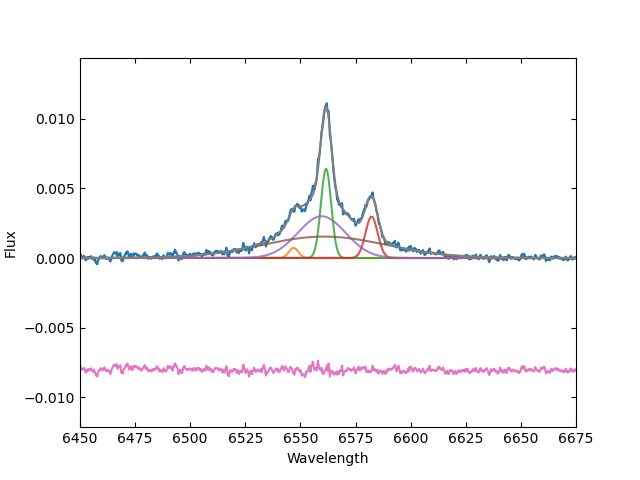

In [17]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

flxsum_scale = np.sum(fit_spectrum[spx_fit[0]:spx_fit[1]+1]*x_bin)
print(f"Flux sum scale : {flxsum_scale:.2e}")
 
n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(fit_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        if (j < nlines-2):
            param += [line_wav[j], 2.7, flx_scale0/nlines]
        elif (j == nlines-2):
            param += [line_wav[j], 10.0, flx_scale0/nlines]
        else:
            param += [line_wav[j], 30.0, flx_scale0/nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param,
                           bounds=((line_wav[0]-3.0, 2.0, 0.0,
                                    line_wav[1]-3.0, 2.0, 0.0,
                                    line_wav[2]-3.0, 2.0, 0.0,
                                    line_wav[3]-5.0, 5.0, 0.0,
                                    line_wav[3]-5.0, 20.0, 0.0),
                                   (line_wav[0], 4.0, 2.0,
                                    line_wav[1], 4.0, 2.0,
                                    line_wav[2], 4.0, 2.0,
                                    line_wav[3]+5.0, 20.0, 10.0,
                                    line_wav[3]+5.0, 50.0, 10.0)))
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    
    mu, e_mu = mpar[3*i], e_mpar[3*i],
    lsig, e_lsig = mpar[3*i+1], e_mpar[3*i+1]
    flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]
    
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")
    vsig = c*lsig / mu
    e_vsig = vsig*np.sqrt((e_mu/mu)**2.0 + (e_lsig/lsig)**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    
    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    
    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(mu-3*lsig)).argmin(),
                np.abs(x_fit-(mu+3*lsig)).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{mpar[3*i+2]:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{mpar[3*i+2]:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flxsum_scale:.2e}\n")

f.close()
g.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-1.0*np.abs(np.max(y_dat)), 1.25*np.abs(np.max(y_dat))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
for i in np.arange(nlines):
    ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar[3*i], mpar[3*i+1], mpar[3*i+2]),
            alpha=0.8)
ax.plot(wav_res, fit_spectrum-line_model(wav_res, *mpar)-0.7*np.abs(np.max(y_dat)))
ax.plot(wav_res, line_model(wav_res, *mpar))
# for i in np.arange(nlines):
#     ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
#     ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
#     ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

In [18]:
# Saving broad components
mpar_b1 = mpar[9:12]
mpar_b2 = mpar[12:]

## 3.2. ${\rm [SII]\lambda\lambda6717,6731}$

100%|██████████| 1000/1000 [00:04<00:00, 207.84it/s]


SII6717 mean: 6715.911 +/- 0.161 Angstrom
SII6717 sigma: 2.983 +/- 0.212 Angstrom
SII6717 sigma: 133.17 +/- 9.480 km/s
SII6717 R: 2490.35 +/- 571.19
SII6717 flux: 1.29e-02 +/- 6.74e-04
SII6717 reduced chi-square: 1.43


SII6731 mean: 6729.969 +/- 0.266 Angstrom
SII6731 sigma: 3.070 +/- 0.233 Angstrom
SII6731 sigma: 136.76 +/- 10.361 km/s
SII6731 R: 2493.45 +/- 571.78
SII6731 flux: 1.00e-02 +/- 6.58e-04
SII6731 reduced chi-square: 1.06




<IPython.core.display.Javascript object>


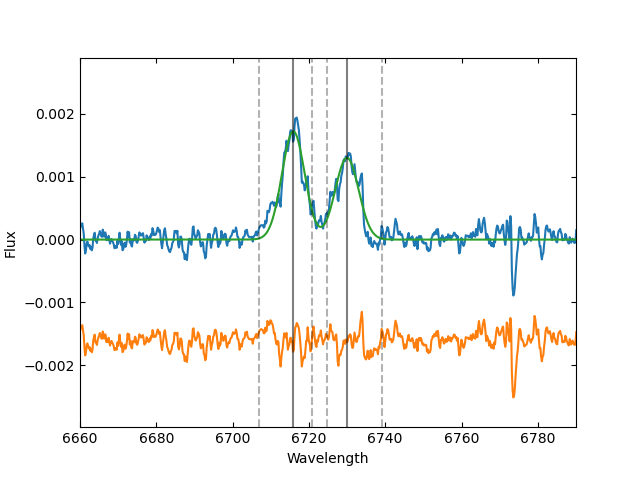

In [19]:
# Line fitting: Monte Carlo simulation of curve_fit ([SII]6717/6731)
line_numbers = 4

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(fit_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0/nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    mu, e_mu = mpar[3*i], e_mpar[3*i],
    lsig, e_lsig = mpar[3*i+1], e_mpar[3*i+1]
    flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]
    
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")
    f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")

    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")
    f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
    vsig = c*lsig / mu
    e_vsig = vsig*np.sqrt((e_mu/mu)**2.0 + (e_lsig/lsig)**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_flux:.2e}  ")

    spx_line = [np.abs(x_fit-(mu-3*lsig)).argmin(),
                np.abs(x_fit-(mu+3*lsig)).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")

f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_dat)-1.0*np.abs(np.max(y_dat)), 1.25*np.abs(np.max(y_dat))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
# for i in np.arange(nlines):
#     ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar[3*i], mpar[3*i+1], mpar[3*i+2]),
#             alpha=0.8)
ax.plot(wav_res, fit_spectrum-line_model(wav_res, *mpar)-0.7*np.abs(np.max(y_dat)))
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

## 3.3. ${\rm [OI]\lambda6300}$

100%|██████████| 1000/1000 [00:01<00:00, 770.74it/s]


OI6300 mean: 6298.246 +/- 0.756 Angstrom
OI6300 sigma: 3.788 +/- 0.684 Angstrom
OI6300 sigma: 180.28 +/- 32.537 km/s
OI6300 R: 2398.24 +/- 553.82
OI6300 flux: 7.90e-03 +/- 1.27e-03
OI6300 reduced chi-square: 1.65




<IPython.core.display.Javascript object>


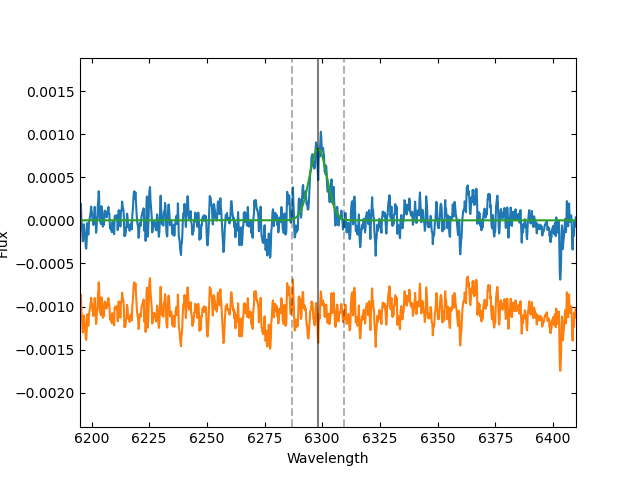

In [20]:
# Line fitting: Monte Carlo simulation of curve_fit ([OI]6300)
line_numbers = 5

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
    y_dat = np.random.normal(fit_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        param += [line_wav[j], 3.0, flx_scale0/nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)

# Printing the results
f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    
    mu, e_mu = mpar[3*i], e_mpar[3*i],
    lsig, e_lsig = mpar[3*i+1], e_mpar[3*i+1]
    flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]
    
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")
    f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")

    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")
    f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
    vsig = c*lsig / mu
    e_vsig = vsig*np.sqrt((e_mu/mu)**2.0 + (e_lsig/lsig)**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    f.write(f"{specR:.2f}  {e_specR:.2f}  ")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")
    f.write(f"{mpar[3*i+2]:.2e}  {e_flux:.2e}  ")

    spx_line = [np.abs(x_fit-(mu-3*lsig)).argmin(),
                np.abs(x_fit-(mu+3*lsig)).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    f.write(f"{rchisq:.2f}\n")
    print("\n")

f.close()
    
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-100.0, wav_fit[1]+100.0])
ax.set_ylim([np.min(y_dat)-1.0*np.abs(np.max(y_dat)), 1.25*np.abs(np.max(y_dat))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
# for i in np.arange(nlines):
#     ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar[3*i], mpar[3*i+1], mpar[3*i+2]),
#             alpha=0.8)
ax.plot(wav_res, fit_spectrum-line_model(wav_res, *mpar)-0.7*np.abs(np.max(y_dat)))
ax.plot(wav_res, line_model(wav_res, *mpar))
for i in np.arange(nlines):
    ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
    ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
    ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

# 4. Additional Tasks for Broad Components

## 4.1. Creating a New Image with Gaussian Profile

In [21]:
from astropy.modeling.models import Gaussian2D
fwhm = 1.10    # arcsec
pixel_scale = 0.1    # arcsec/pix
x_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
y_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
print(x_sigma, y_sigma)
g2d = Gaussian2D(amplitude = 1, x_mean = yInd, y_mean = xInd, x_stddev = x_sigma, y_stddev = y_sigma)
img_g2d = g2d(*np.mgrid[0:d_sci.shape[1], 0:d_sci.shape[2]])

4.671269901584105 4.671269901584105


<IPython.core.display.Javascript object>


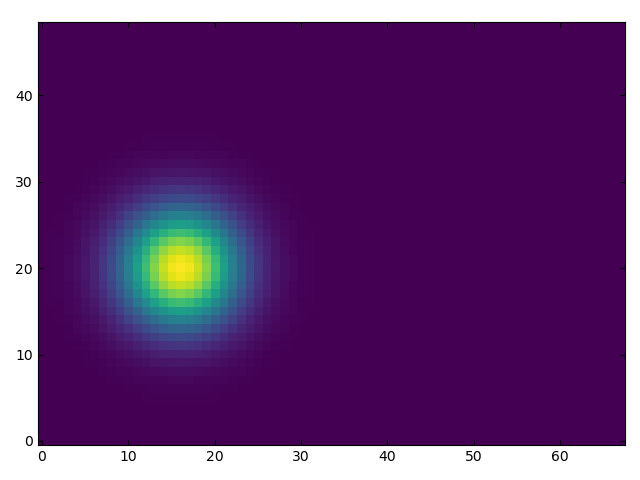

In [22]:
fig, ax = plt.subplots()
ax.imshow(img_g2d, origin = 'lower')
plt.tight_layout()

fits.writeto("g2d.fits", img_g2d, overwrite=True)

## 4.2. Checking for Spectra in an Arbitrary Bin

### 4.2.1. Setting an Arbitrary Bin

In [23]:
nbin = 264    # arbitrary bin

print(f"Bin {nbin:d}")

fit_spectrum = dat[:, nbin]
fit_variance = var[:, nbin]
fit_continuum = cont[:, nbin]

Bin 264


In [24]:
indices = np.argwhere(data_vbin == nbin)
print("The (x,y) indices of the bin")
print(indices)

The (x,y) indices of the bin
[[18 27]
 [18 28]
 [18 29]
 [18 30]
 [19 27]
 [19 28]
 [19 29]
 [19 30]]


In [25]:
npix = indices.shape[0]
print(f"Number of pixels in the bin: {npix:d}")

Number of pixels in the bin: 8


### 4.2.2. Creating an Image of Initial Guess for the Broad Component Factors

In [26]:
print("Gaussian factors of this bin:")
img_g2d[indices[:, 0], indices[:, 1]]

Gaussian factors of this bin:


array([0.0570262 , 0.03366604, 0.01898484, 0.01022631, 0.06108416,
       0.03606171, 0.0203358 , 0.01095401])

In [27]:
fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
print(f"Mean Gaussian factor of broad components: {fac:.4f}")

Mean Gaussian factor of broad components: 0.0310


<IPython.core.display.Javascript object>


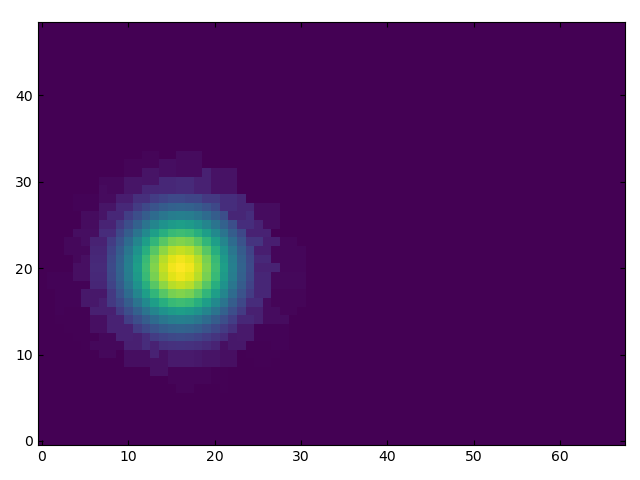

In [28]:
gfac = np.zeros_like(img_g2d)
for b in np.unique(data_vbin):
    binwhere = np.argwhere(data_vbin == b)
    if (b == -99):
        fc = 0.0
    else:
        fc = np.sum(img_g2d[binwhere[:, 0], binwhere[:, 1]])
#         fc = img_g2d[binwhere[:, 0], binwhere[:, 1]].max()
    gfac[data_vbin == b] = fc / binwhere.shape[0]
    
fig, ax = plt.subplots()
ax.imshow(gfac, origin = 'lower', vmin=0.01, vmax=1.0)
plt.tight_layout()
fits.writeto("gfac.fits", gfac, overwrite=True)

### 4.2.3. Plotting the Spectra for Visual Check

<IPython.core.display.Javascript object>


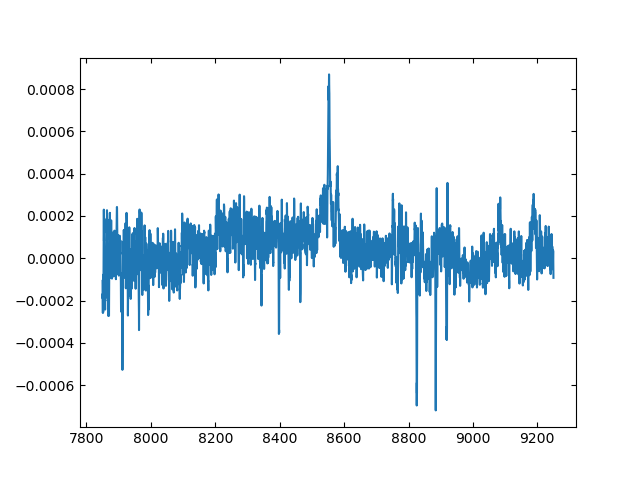

In [29]:
line_numbers = 3
nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers)

fig, ax = plt.subplots()
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum)
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]))
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2]))
ax.plot(wav_obs, binned_spectrum[:, nbin] / indices.shape[0])

<IPython.core.display.Javascript object>


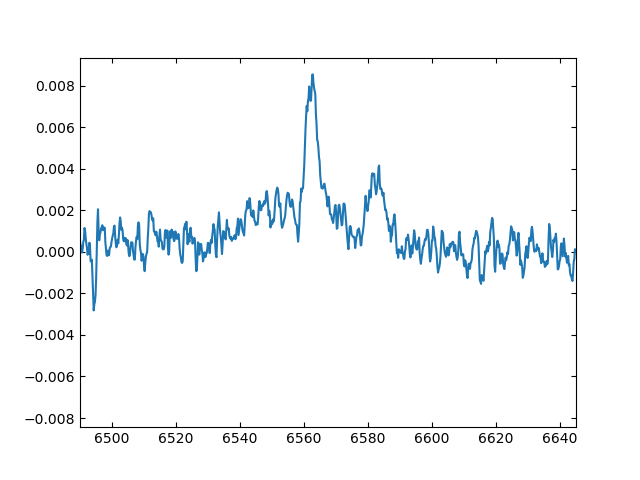

In [30]:
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - \
        (gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]) + \
         gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2])))

### 4.2.4. Line Fitting with Fixing Broad Components

Flux sum scale : 1.53e-01


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


0.031042383931295013 ---> 0.06570417177675505 ---> 0.5256333742140404
0.0
NII6548 mean: 6544.728 +/- 0.000 Angstrom
NII6548 sigma: 3.000 +/- 0.000 Angstrom
NII6548 sigma: 137.42 +/- 0.000 km/s
NII6548 R: 2452.60 +/- 564.00
NII6548 flux: 6.57e-03 +/- 0.00e+00
NII6548 reduced chi-square: 3.68


Halpha mean: 6562.487 +/- 0.000 Angstrom
Halpha sigma: 1.649 +/- 0.000 Angstrom
Halpha sigma: 75.33 +/- 0.000 km/s
Halpha R: 2456.51 +/- 564.74
Halpha flux: 2.55e-02 +/- 0.00e+00
Halpha reduced chi-square: 29.75


NII6584 mean: 6582.741 +/- 0.000 Angstrom
NII6584 sigma: 2.272 +/- 0.000 Angstrom
NII6584 sigma: 103.46 +/- 0.000 km/s
NII6584 R: 2460.98 +/- 565.59
NII6584 flux: 1.68e-02 +/- 0.00e+00
NII6584 reduced chi-square: 6.04


Broad1 mean: 6559.637 +/- 0.000 Angstrom
Broad1 sigma: 10.807 +/- 0.000 Angstrom
Broad1 sigma: 493.93 +/- 0.000 km/s
Broad1 R: 2455.89 +/- 564.62
Broad1 flux: 4.27e-02 +/- 0.00e+00
Broad1 reduced chi-square: 7.38


Broad2 mean: 6560.756 +/- 0.000 Angstrom
Broad2 sigma: 28

<IPython.core.display.Javascript object>


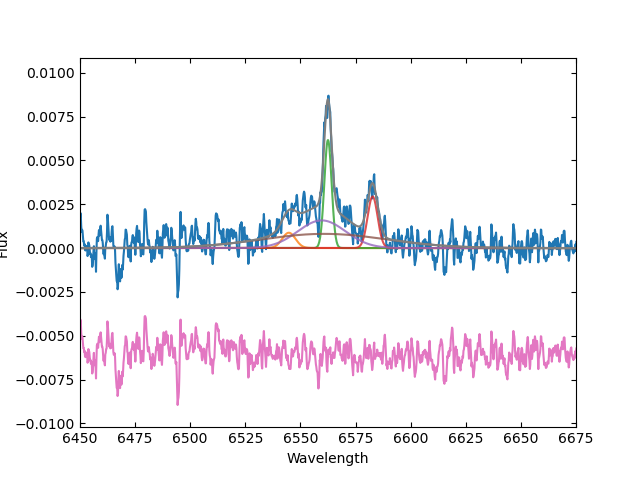

In [31]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, line_names, line_wav, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_fit = wav_res[spx_fit[0]:spx_fit[1]+1]

flxsum_scale = np.sum(fit_spectrum[spx_fit[0]:spx_fit[1]+1]*x_bin)
print(f"Flux sum scale : {flxsum_scale:.2e}")

n_fit = 1
mpopt = []
for i in tqdm.trange(n_fit):
    y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
#     y_dat = np.random.normal(fit_spectrum[spx_fit[0]:spx_fit[1]+1], np.sqrt(y_var))
    y_dat = fit_spectrum[spx_fit[0]:spx_fit[1]+1]# / indices.shape[0]
    y_dat /= indices.shape[0]
    y_fit = y_dat
    flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
    
    param = []
    for j in np.arange(nlines):
        if (j < nlines-2):
            param += [line_wav[j], 2.7, flx_scale0/nlines / indices.shape[0]]
    param += [fac]
            
    line_model2 = lambda x, *pars: gauss_cdf_scale(x, pars[0], pars[1], pars[2]) + \
                                   gauss_cdf_scale(x, pars[3], pars[4], pars[5]) + \
                                   gauss_cdf_scale(x, pars[6], pars[7], pars[8]) + \
                                   pars[9] * \
                                  (gauss_cdf_scale(x, mpar_b1[0], mpar_b1[1], mpar_b1[2]) + \
                                   gauss_cdf_scale(x, mpar_b2[0], mpar_b2[1], mpar_b2[2]))

    popt, pcov = curve_fit(line_model2, x_fit, y_fit, param,
                           bounds=((line_wav[0]-6.0, 0.75, 0.0,
                                    line_wav[1]-6.0, 0.75, 0.0,
                                    line_wav[2]-6.0, 0.75, 0.0,
                                    0.0),
                                   (line_wav[0]+6.0, 3.00, 2.0,
                                    line_wav[1]+6.0, 3.00, 2.0,
                                    line_wav[2]+6.0, 3.00, 2.0,
                                    1.0)))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
ffac = mpar[-1]
print(fac, "--->", ffac, "--->", ffac*indices.shape[0])
mpar[2::3] *= indices.shape[0]
mpar = np.array(list(mpar[:9])+ \
                [mpar_b1[0], mpar_b1[1], mpar[-1]*mpar_b1[2]*indices.shape[0],
                 mpar_b2[0], mpar_b2[1], mpar[-1]*mpar_b2[2]*indices.shape[0]])
e_mpar = np.std(mpopt, axis=0)
e_ffac = e_mpar[-1]
print(e_ffac)
e_mpar[2::3] *= indices.shape[0]
e_mpar = np.array(list(e_mpar[:9])+ \
                  [0.0, 0.0, e_mpar[-1]*mpar_b1[2]*indices.shape[0],
                   0.0, 0.0, e_mpar[-1]*mpar_b2[2]*indices.shape[0]])

# Printing the results
for i in np.arange(nlines):
    
    mu, e_mu = mpar[3*i], e_mpar[3*i],
    lsig, e_lsig = mpar[3*i+1], e_mpar[3*i+1]
    flux, e_flux = mpar[3*i+2], e_mpar[3*i+2]
    
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")
    vsig = c*lsig / mu
    e_vsig = vsig*np.sqrt((e_mu/mu)**2.0 + (e_lsig/lsig)**2.0)
    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    
    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")
    
    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(mu-3*lsig)).argmin(),
                np.abs(x_fit-(mu+3*lsig)).argmin()]
    chisq = ((y_fit-line_model(x_fit, *mpar))/np.sqrt(y_var))**2.
    dof = len(y_fit[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
      
# Figure
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
y_dat *= indices.shape[0]
ax.set_ylim([np.min(y_dat)-1.0*np.abs(np.max(y_dat)), 1.25*np.abs(np.max(y_dat))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
for i in np.arange(nlines):
#     if (i < 3):
#         flx = indices.shape[0]
#     else:
#         flx = 1
    ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar[3*i], mpar[3*i+1], mpar[3*i+2]),
            alpha=0.8)
ax.plot(wav_res, fit_spectrum-line_model(wav_res, *mpar)-0.7*np.abs(np.max(y_dat)))
ax.plot(wav_res, line_model(wav_res, *mpar))
# for i in np.arange(nlines):
#     ax.axvline(mpar[3*i], color='k', linestyle='-', alpha=0.5)
#     ax.axvline(mpar[3*i]-3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)
#     ax.axvline(mpar[3*i]+3*mpar[3*i+1], color='k', linestyle='--', alpha=0.3)

### 4.2.5. Check for Broad-Component-Subtracted Spectra

<IPython.core.display.Javascript object>


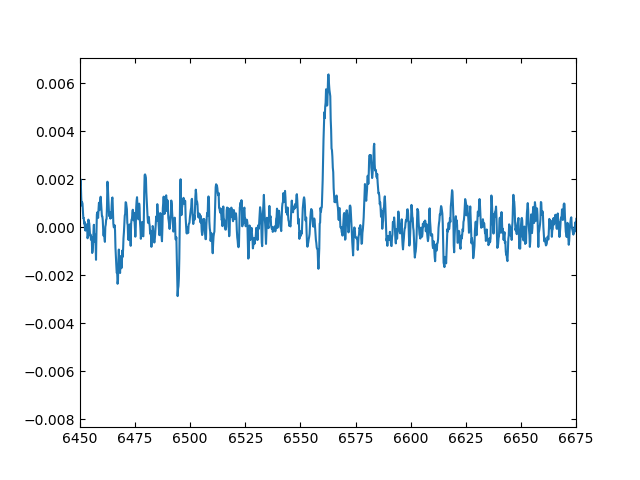

In [32]:
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - \
        ffac*indices.shape[0] * \
        (gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], mpar_b1[2]) + \
         gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], mpar_b2[2])))